In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
import locale
import pandas as pd
from tensorflow import keras
from utils.helper import (
    folder_to_sequence,
    MinMaxScaler_AE,
)

import sys
sys.path.append("../")
from train_model import PARAMETERS

locale.setlocale(locale.LC_ALL, "pt_BR.UTF-8")

plt.style.use(["science", "ieee", "notebook"])

plt.rcParams["font.size"] = 10
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.figsize"] = (12, 4) #16 é a largura do artigo
plt.rcParams['axes.formatter.use_locale'] = True

In [3]:
# carregando os dados para a memória
DEFAULT_WS = PARAMETERS["window_size"]
Xnormal, Ynormal = folder_to_sequence("VIDRO-B3", DEFAULT_WS)

anomalies_data = [
    folder_to_sequence("ANOMALIAS/B3+200g", DEFAULT_WS),
    folder_to_sequence("ANOMALIAS/B3-200g", DEFAULT_WS),
    folder_to_sequence("VIDRO-B2", DEFAULT_WS),
    folder_to_sequence("PAINCO", DEFAULT_WS),
]

Xanomalies = [data[0] for data in anomalies_data]
Yanomalies = [data[1] for data in anomalies_data]

Xtransient, Ytransient = folder_to_sequence("ANOMALIAS/Transiente", DEFAULT_WS)

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 40.71it/s]


In [14]:
import optuna

study = optuna.load_study(
    study_name="LSTM-v2",
    storage="sqlite:///../models/optuna_study.db"
)
# study.trials_dataframe()

model_path = study.best_trial.user_attrs["model_path"]

c:\Users\vinim\OneDrive\Documentos\Projetos\TCC\fluidization-AE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
Xscaler = MinMaxScaler_AE()
Yscaler = MinMaxScaler_AE()

Xscaler.fit(Xnormal)
Yscaler.fit(Ynormal)

# Xanomalies = [Xscaler.transform(data) for data in Xanomalies]
# Yanomalies = [Yscaler.transform(data) for data in Yanomalies]

seq2seq = keras.models.load_model(model_path)
seq2seq.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 96)         │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 1)          │            97 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,525 (1.28 MB)

 Trainable params: 111,841 (436.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 223,684 (873.77 KB)

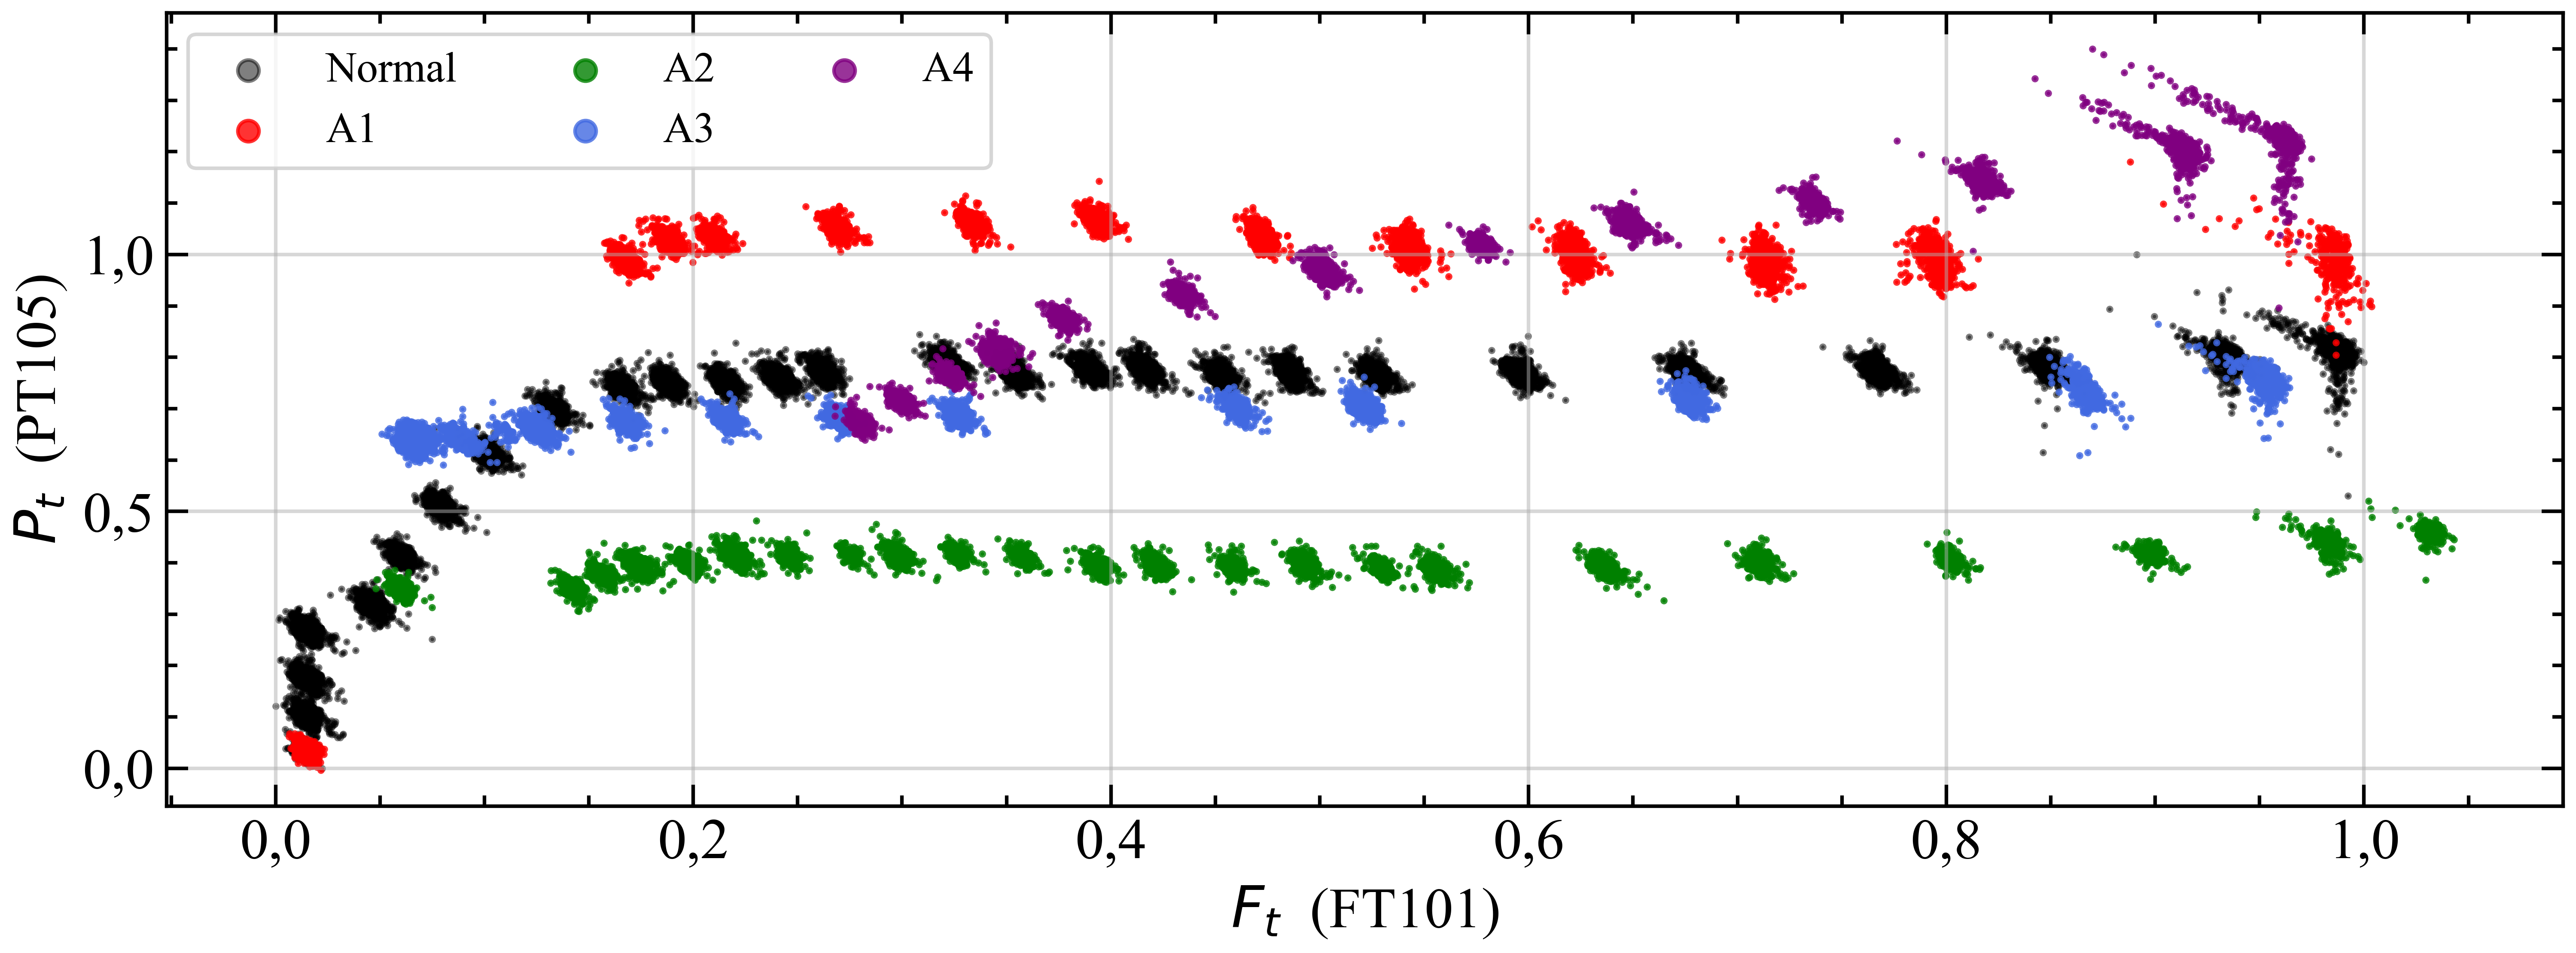

In [32]:
plt.grid(alpha=0.5)
plt.scatter(Xscaler.transform(Xnormal)[:, 0, 0], Yscaler.transform(Ynormal)[:, 0, 0], label="Normal", s=1, alpha=0.5)

plt.scatter(Xscaler.transform(Xanomalies[0])[:, 0, 0], Yscaler.transform(Yanomalies[0])[:, 0, 0], label="A1", s=1, alpha=0.8, c="r")
plt.scatter(Xscaler.transform(Xanomalies[1])[:, 0, 0], Yscaler.transform(Yanomalies[1])[:, 0, 0], label="A2", s=1, alpha=0.8, c="g")
plt.scatter(Xscaler.transform(Xanomalies[2])[:, 0, 0], Yscaler.transform(Yanomalies[2])[:, 0, 0], label="A3", s=1, alpha=0.8, c="royalblue")
plt.scatter(Xscaler.transform(Xanomalies[3])[:, 0, 0], Yscaler.transform(Yanomalies[3])[:, 0, 0], label="A4", s=1, alpha=0.8, c="purple")


plt.xlabel(r"$F_t$  (FT101)")
plt.ylabel(r"$P_t$  (PT105)")

lgnd = plt.legend(ncol=3, loc="upper left", fontsize=12, frameon=True)
lgnd.legend_handles[0]._sizes = [35]
lgnd.legend_handles[1]._sizes = [35]
lgnd.legend_handles[2]._sizes = [35]
lgnd.legend_handles[3]._sizes = [35]
lgnd.legend_handles[4]._sizes = [35]

plt.savefig("../images/scatter.png", dpi=300, bbox_inches="tight")

In [22]:
# 1) Analisar os erros no conjunto de treino


def get_error_dist(Xdata: np.ndarray, Ydata: np.ndarray) -> np.ndarray:
    xnorm = Xscaler.transform(Xdata)
    ypred = seq2seq.predict(xnorm)

    ynorm = Yscaler.transform(Ydata)

    ynorm_squeezed = ynorm.squeeze(axis=-1)
    ypred_squeezed = ypred

    print(f"ynorm shape: {ynorm_squeezed.shape}")
    print(f"ypred shape: {ypred.shape}")

    # Garante que as formas são compatíveis para subtração
    if ynorm_squeezed.shape != ypred_squeezed.shape:
         # Tenta ajustar se a diferença for apenas na dimensão da janela
         min_len = min(ynorm_squeezed.shape[1], ypred_squeezed.shape[1])
         errors = np.mean(np.abs(ynorm_squeezed[:, :min_len] - ypred_squeezed[:, :min_len]), axis=1)
         print(f"Warning: Shape mismatch in get_error_dist ({ynorm_squeezed.shape} vs {ypred_squeezed.shape}). Comparing up to minimum length ({min_len}).")
    else:
         # Calcula o erro médio absoluto entre Y normalizado e Y previsto por janela
         errors = np.mean(np.abs(ynorm_squeezed - ypred_squeezed), axis=1)

    return errors


def plot_error_dist(
    error_dists: list[np.ndarray],
    threshold: float,
    colors: list[str],
    labels: list[str],
):
    fig, ax = plt.subplots()
    ax.grid(zorder=0)
    for error_dist, label, color in zip(error_dists, labels, colors):
        sns.histplot(
            error_dist,
            kde=True,
            bins=50,
            color=color,
            stat="percent",
            ax=ax,
            label=label,
            alpha=0.6,
            zorder=3
        )

    ax.set_ylabel(r"Porcentagem (%)")
    ax.set_xlabel(r"$E_t$")
    ax.axvline(threshold, color="black", linestyle="--", label="Limiar")
    ax.legend(ncols=3, loc="upper right", frameon=True, fontsize=12)
    # ax.legend(title=f"Janela > Limiar: {get_accuracy(error_dist, threshold) * 100:.2f}%")
    return fig, ax

def plot_anomalies(
    Ydata: np.ndarray,
    errors: np.ndarray,
    max_error: float,
    ax: plt.Axes = None,
):
    anomaly_points = np.where(errors > max_error)[0]

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    time_idx = np.arange(len(Ydata))
    ax.plot(time_idx, Ydata[:, 0, 0], label="Sinal Original (Y)")

    if len(anomaly_points) > 0:
        ax.scatter(
            time_idx[anomaly_points],
            Ydata[anomaly_points, 0, 0],
            c="r",
            label="Pontos Anômalos"
        )

    ax.set_ylabel(r"$(-\Delta$P$_N)$")

    return fig, ax

def get_accuracy(errors: np.ndarray, threshold: float) -> float:
    anomalies = errors > threshold
    accuracy: float = np.mean(anomalies)
    return accuracy

In [20]:
normal_err = get_error_dist(Xnormal, Ynormal)
threshold = np.percentile(normal_err, 95)

1033/1033 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
ynorm shape: (33031, 20)
ypred shape: (33031, 20)


Text(0.5, 0, 'Instante')

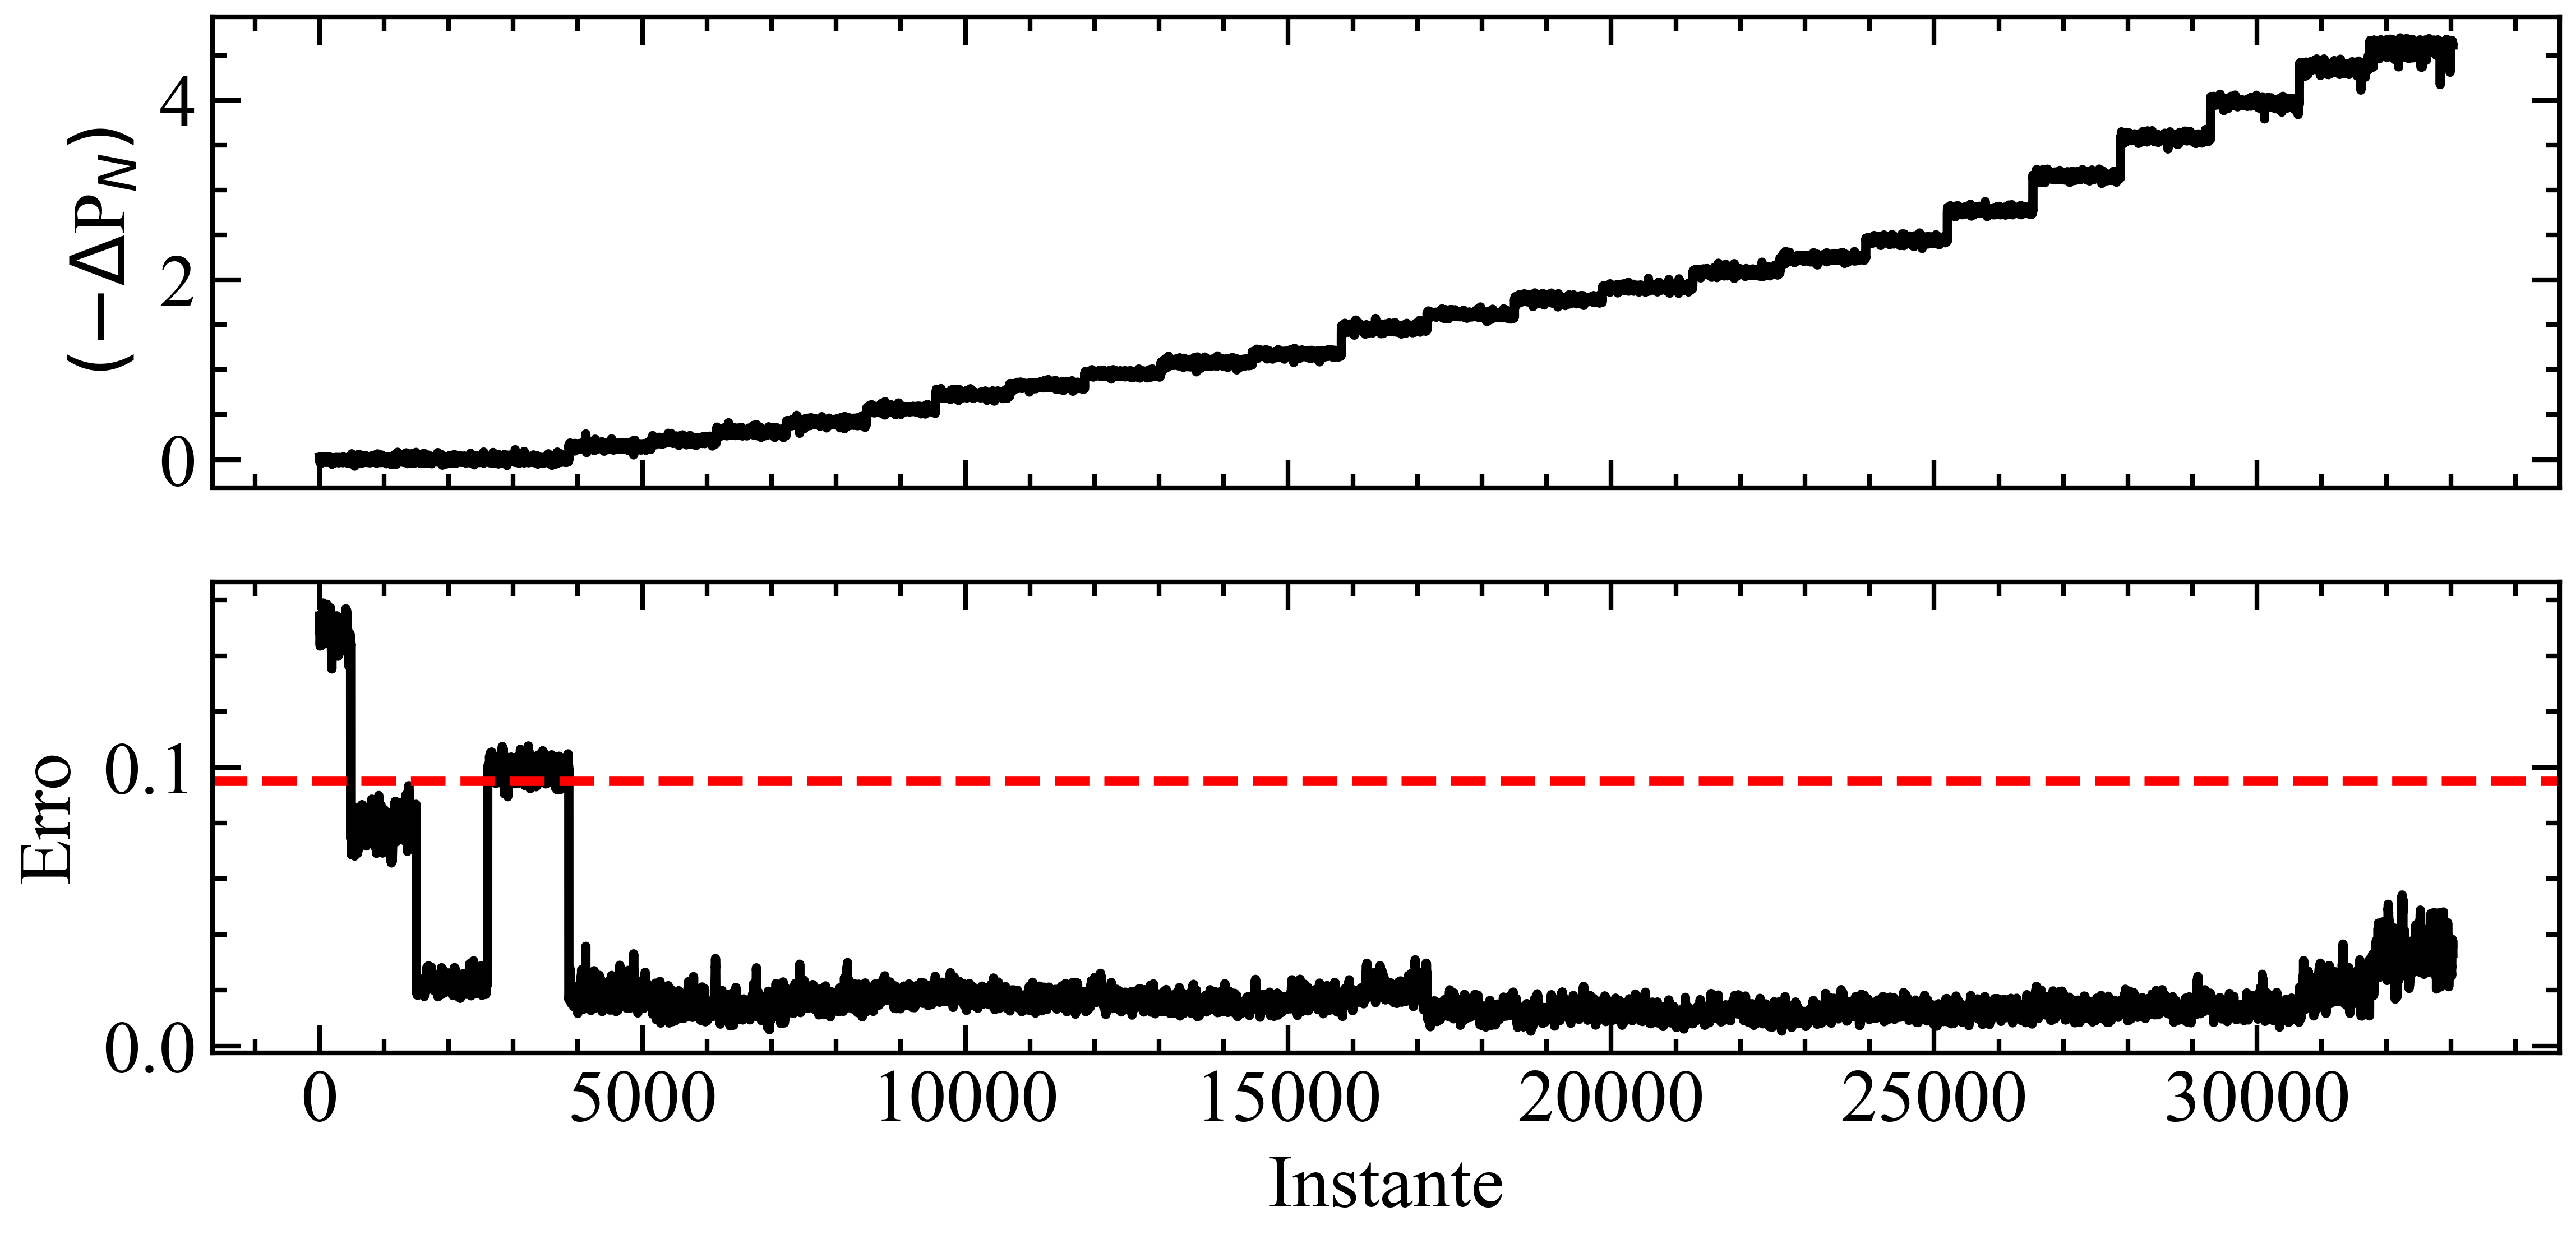

In [28]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(Xnormal[:, 0, 0], label="Dados")
ax[0].set_ylabel(r"$(-\Delta$P$_N)$")

ax[1].set_ylabel("Erro")
ax[1].plot(normal_err, label="Erro")

ax[1].axhline(threshold, color="red", linestyle="--", label="Limiar")
ax[1].set_xlabel("Instante")

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
ynorm shape: (8985, 20)
ypred shape: (8985, 20)


Text(0.5, 0, 'Instante')

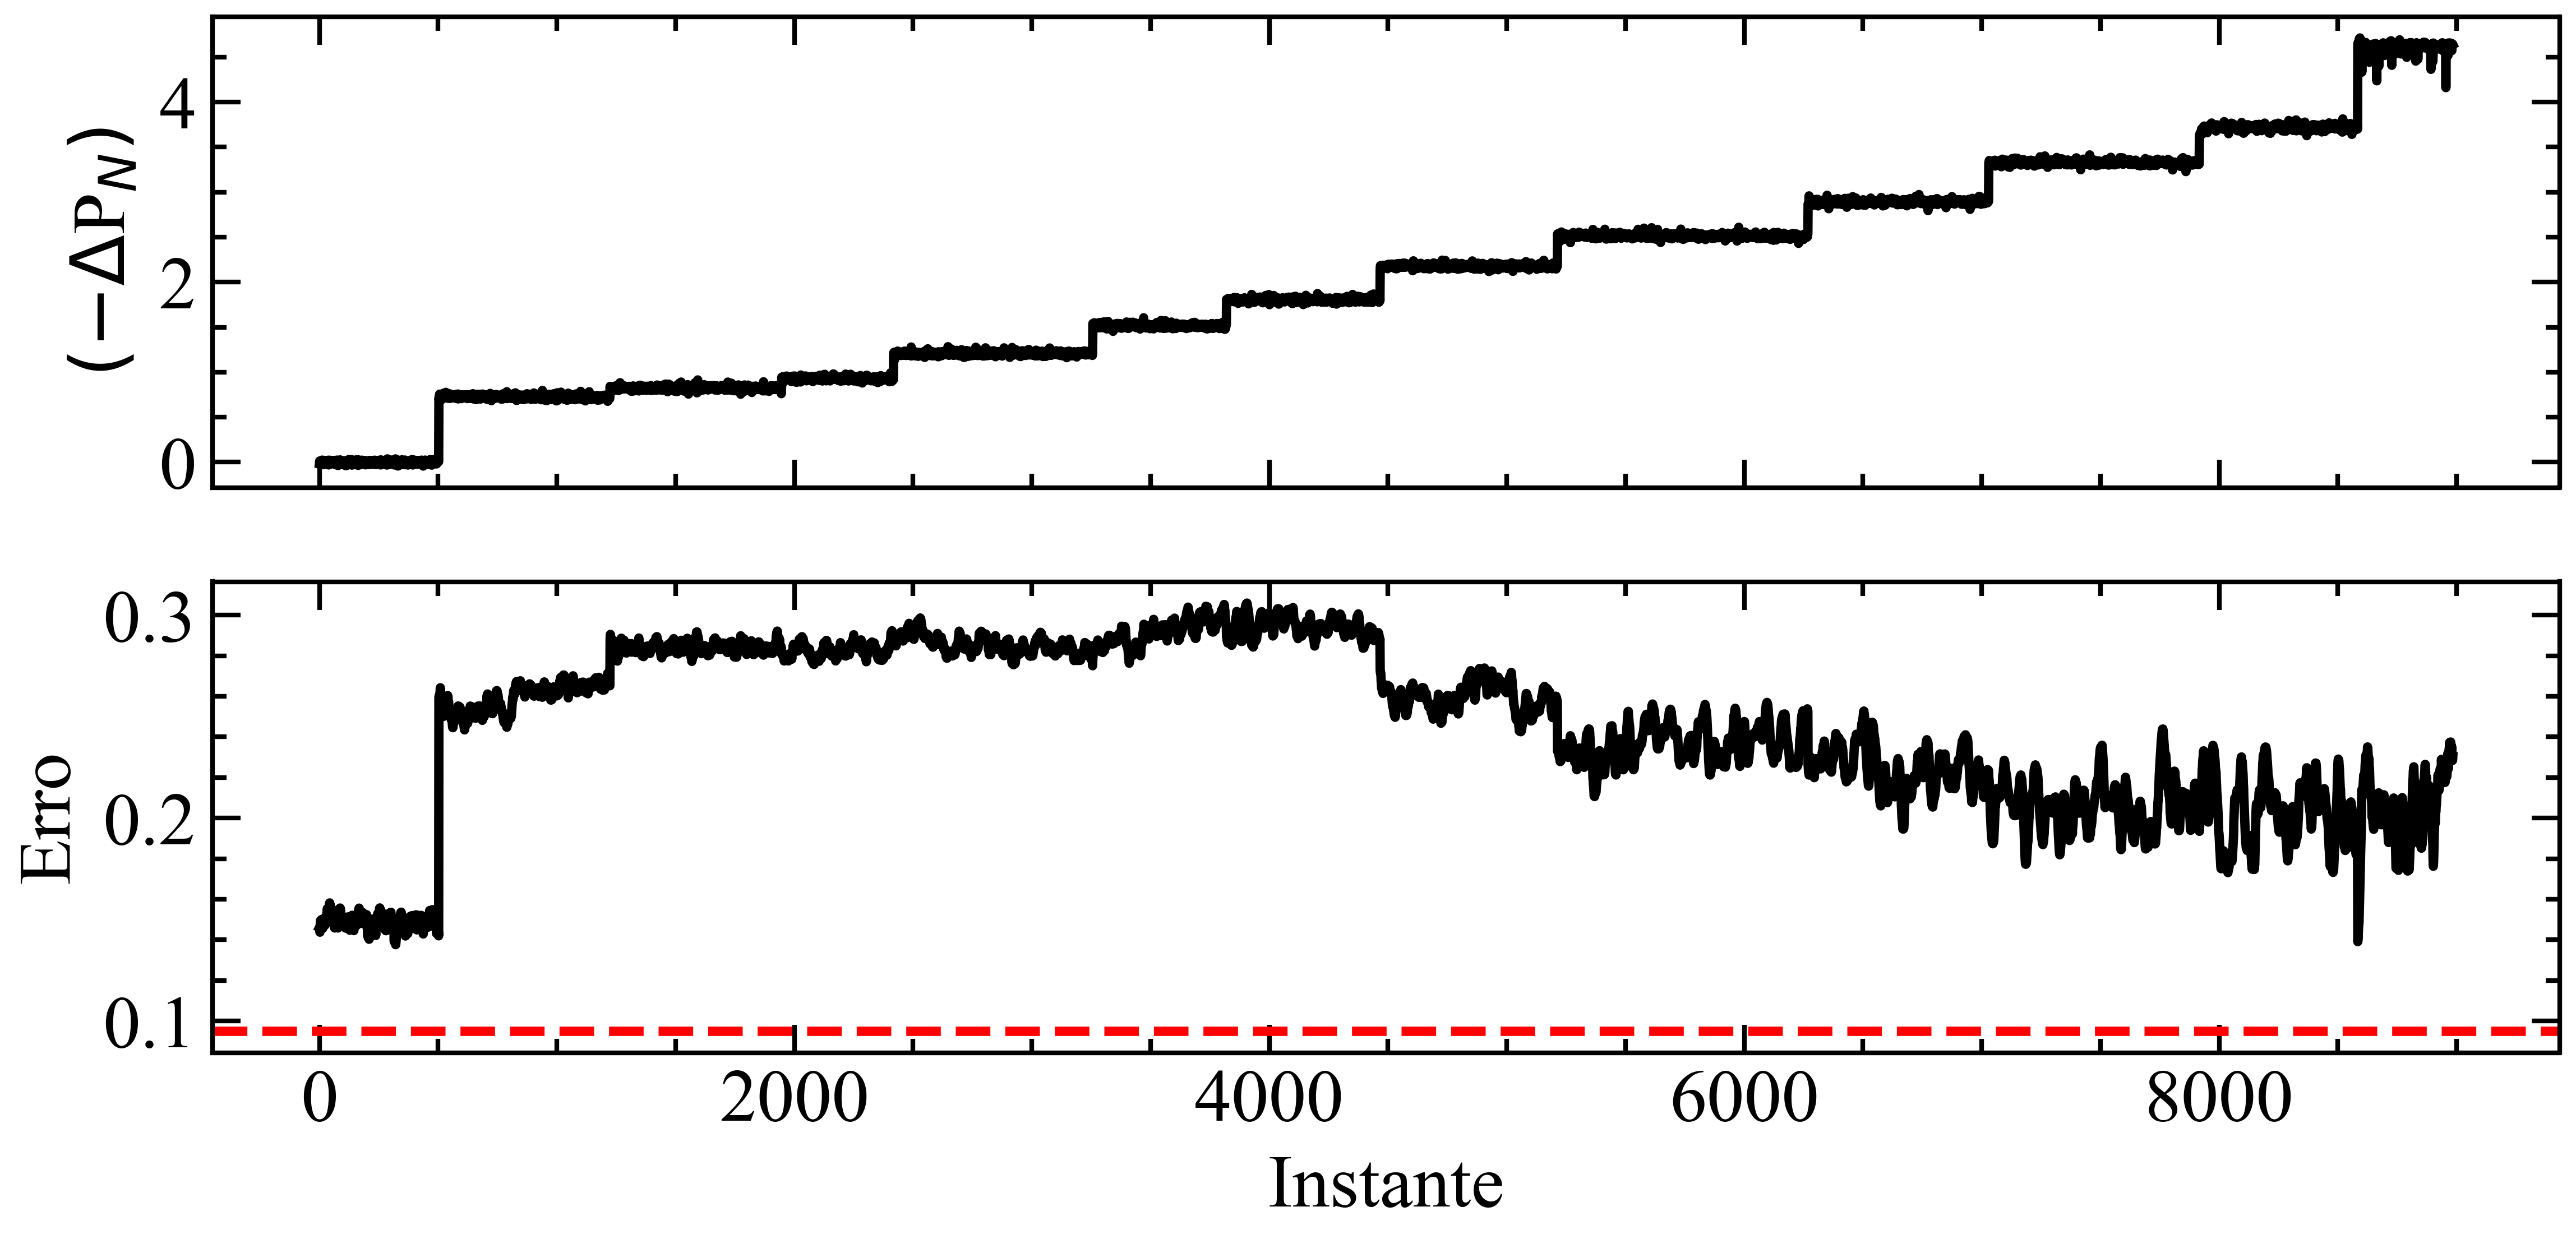

In [42]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(Xanomalies[0][:, 0, 0], label="Dados")
ax[0].set_ylabel(r"$(-\Delta$P$_N)$")

ax[1].set_ylabel("Erro")
ax[1].plot(get_error_dist(Xanomalies[0], Yanomalies[0]), label="Erro")

ax[1].axhline(threshold, color="red", linestyle="--", label="Limiar")
ax[1].set_xlabel("Instante")

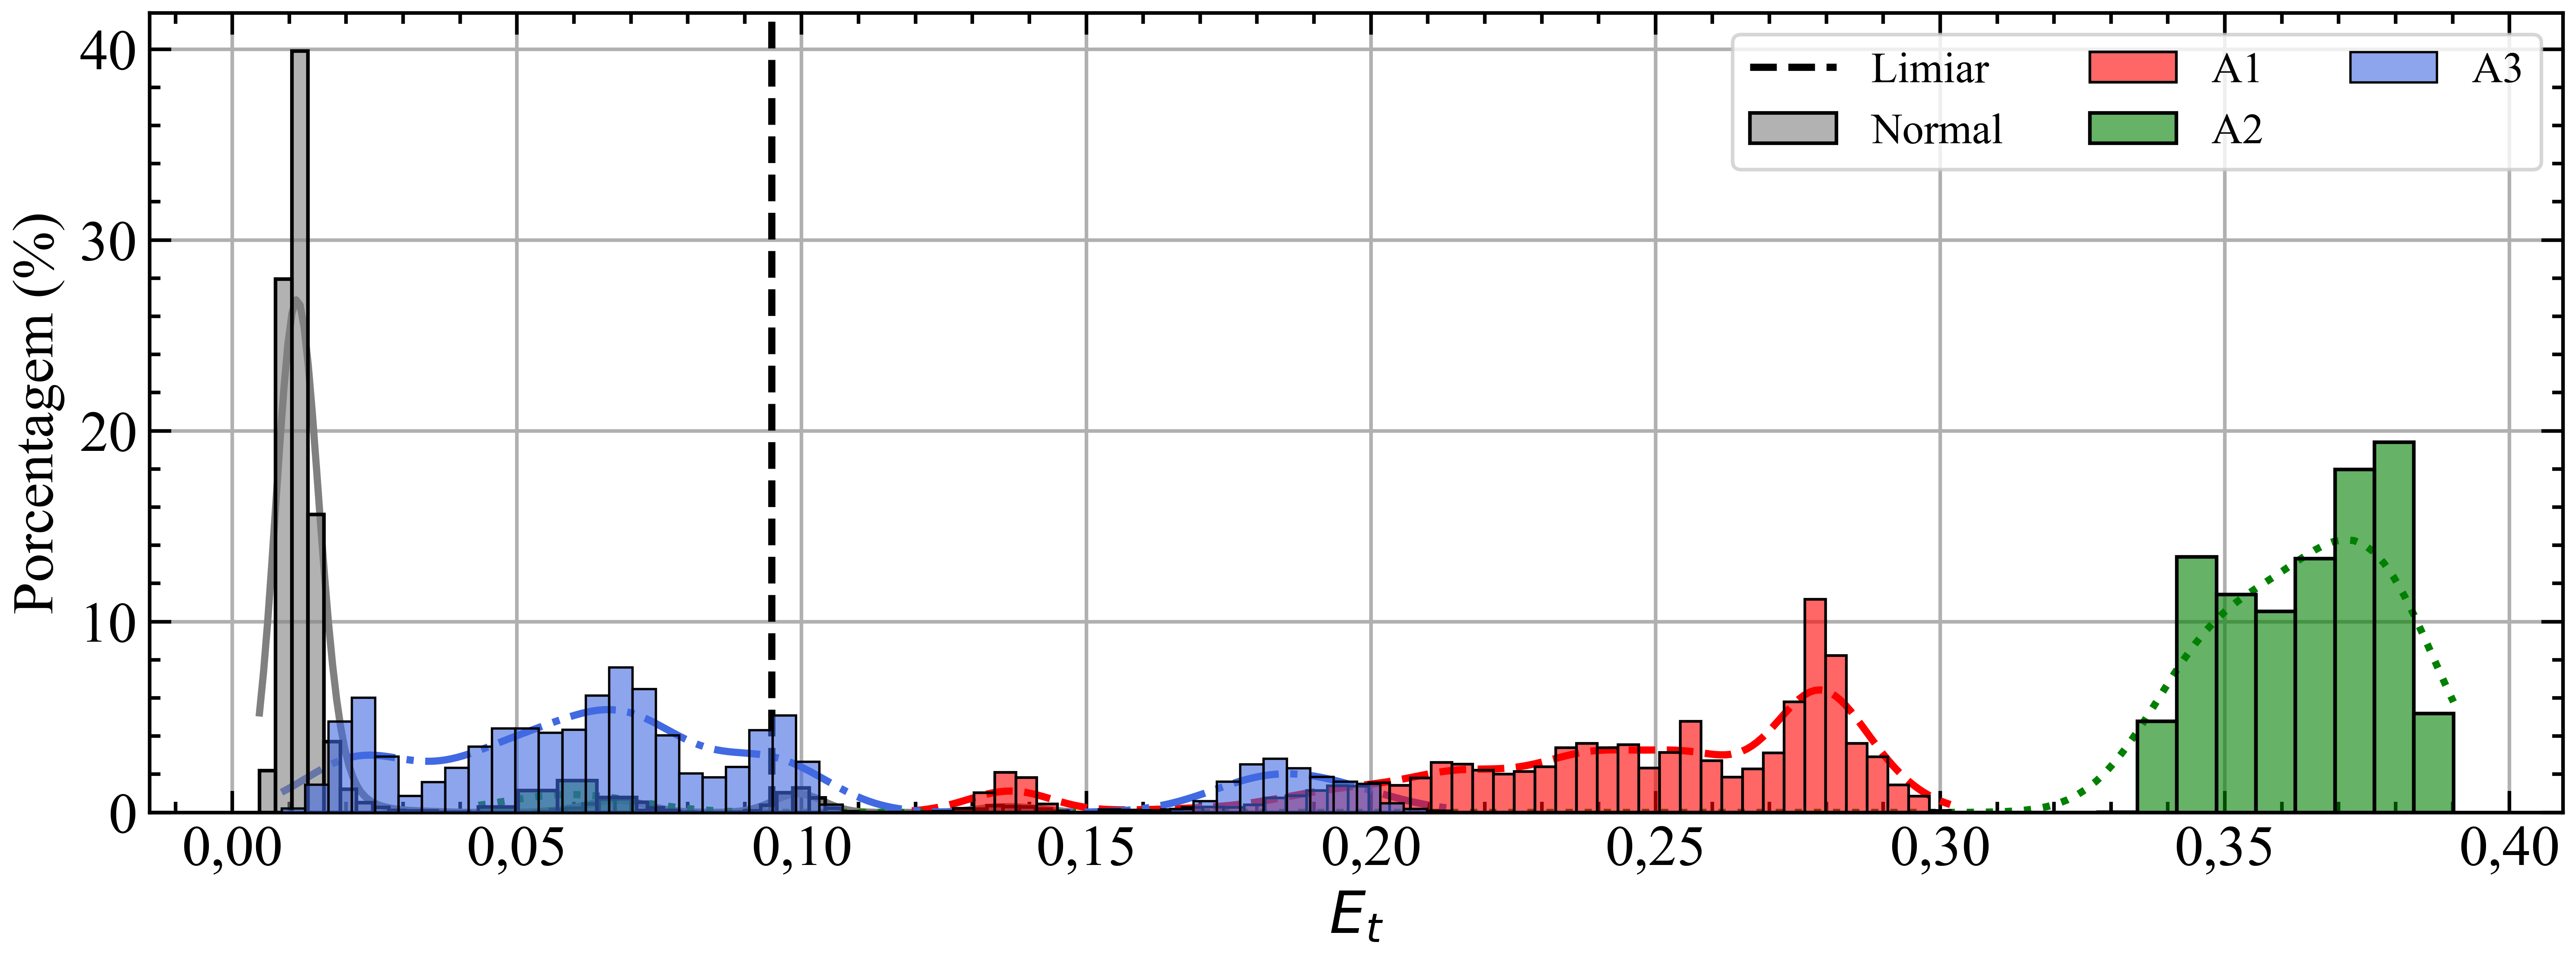

In [26]:
all_errors = [normal_err] + [get_error_dist(xanomaly, yanomaly) for xanomaly, yanomaly in zip(Xanomalies, Yanomalies)]
all_labels = ["Normal"] + [f"A{i+1}" for i in range(len(Xanomalies))]
all_colors = ["grey"] + ["red", "green", "royalblue"]

IDX: int = 6
fig, ax = plot_error_dist(all_errors[:IDX], threshold, all_colors[:IDX], all_labels[:IDX])
plt.savefig("../images/error_dist.png", dpi=300, bbox_inches="tight")

In [28]:
# plot_error_dist(errors[3], threshold, "green")

In [29]:
def calculate_thresholds_and_accuracies(
    Xnormal_data: np.ndarray,
    Ynormal_data: np.ndarray,
    Xanomaly_list: list[np.ndarray],
    Yanomaly_list: list[np.ndarray],
    percentiles=[90, 95, 100]
) -> pd.DataFrame:
    """
    Calcula limiares de detecção de anomalias e retorna uma tabela com as acurácias
    """

    normal_errors = get_error_dist(Xnormal_data, Ynormal_data)

    thresholds = {p: np.percentile(normal_errors, p) for p in percentiles}
    accuracies = {p: [] for p in percentiles}

    # Calculate thresholds based on percentiles
    for Xanomaly, Yanomaly in zip(Xanomaly_list, Yanomaly_list):
        anomaly_errors = get_error_dist(Xanomaly, Yanomaly)

        # Calculate accuracy for each threshold
        for p in percentiles:
            threshold = thresholds[p]
            accuracy = get_accuracy(anomaly_errors, threshold)
            accuracies[p].append(accuracy)

    # Create a DataFrame to store the results
    results = pd.DataFrame(
        {
            "Percentil": percentiles,
            "Limiar": [thresholds[p] for p in percentiles],
        }
    )

    anomaly_names = ["A1", "A2", "A3", "A4"]
    for i, name in enumerate(anomaly_names):
        results[f"{name} Acc (%)"] = [
            accuracies[p][i] * 100 for p in percentiles
        ]

    results.set_index("Percentil", inplace=True)
    return results


# Calcular a tabela de limiares e acurácias
results_table = calculate_thresholds_and_accuracies(
    Xnormal, Ynormal, Xanomalies, Yanomalies, percentiles=[90, 95, 99]
)
print(results_table)

1033/1033 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
ynorm shape: (33031, 20)
ypred shape: (33031, 20)
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
ynorm shape: (8985, 20)
ypred shape: (8985, 20)
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
ynorm shape: (8665, 20)
ypred shape: (8665, 20)
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
ynorm shape: (7603, 20)
ypred shape: (7603, 20)
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
ynorm shape: (7159, 20)
ypred shape: (7159, 20)
             Limiar  A1 Acc (%)  A2 Acc (%)  A3 Acc (%)  A4 Acc (%)
Percentil                                                          
90         0.020207  100.000000  100.000000   94.607392   98.938399
95         0.094690  100.000000   95.995384   24.332500   81.505797
99         0.134237   98.530885   95.995384   15.914770   71.490432


In [30]:
caption = "Acurácia de detecção de anomalias para diferentes limiares."
position = "H"
label = "tab:acuracias"
header = [
    "Limiar",
    "A1",
    "A2",
    "A3",
    "A4",
]

print(
    results_table.to_latex(
        float_format="%.2f",
        decimal=",",
        caption=caption,
        position=position,
        label=label,
        column_format="c"*(len(Xanomalies) + 1),
        header=header,
    )
)

\begin{table}[H]
\caption{Acurácia de detecção de anomalias para diferentes limiares.}
\label{tab:acuracias}
\begin{tabular}{ccccc}
\toprule
 & Limiar & A1 & A2 & A3 & A4 \\
Percentil &  &  &  &  &  \\
\midrule
90 & 0,02 & 100,00 & 100,00 & 94,61 & 98,94 \\
95 & 0,09 & 100,00 & 96,00 & 24,33 & 81,51 \\
99 & 0,13 & 98,53 & 96,00 & 15,91 & 71,49 \\
\bottomrule
\end{tabular}
\end{table}



In [31]:
results_table[["A1 Acc (%)", "A2 Acc (%)", "A3 Acc (%)", "A4 Acc (%)"]].mean(axis=1)

Percentil
90    98.386448
95    75.458420
99    70.482868
dtype: float64